# RTML Final 2021 - 2.5 Hrs (9.13 - 11:43)

In this exam, we'll have some practical exercises using RNNs and some short answer questions regarding the Transformer/attention
and reinforcement learning.

Consider the AGNews text classification dataset:

In [1]:
# !wget http://www.cs.ait.ac.th/~mdailey/data.zip

In [2]:
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = AG_NEWS(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()

def clean(line):
    line = line.replace('\\', ' ')
    return line

labels = {}
for (label, line) in train_iter:
    if label in labels:
        labels[label] += 1
    else:
        labels[label] = 1
    counter.update(tokenizer(clean(line)))

vocab = Vocab(counter, min_freq=1)

print('Label frequencies:', labels)
print('A few token frequencies:', vocab.freqs.most_common(5))
print('Label meanings: 1: World news, 2: Sports news, 3: Business news, 4: Sci/Tech news')

Label frequencies: {3: 30000, 4: 30000, 2: 30000, 1: 30000}
A few token frequencies: [('.', 225971), ('the', 205040), (',', 165685), ('to', 119817), ('a', 110942)]
Label meanings: 1: World news, 2: Sports news, 3: Business news, 4: Sci/Tech news


Here's how we can get a sequence of tokens for a sentence with the cleaner, tokenizer, and vocabulary:

In [3]:
[vocab[token] for token in tokenizer(clean('Bangkok, or The Big Mango, is one of the great cities of Asia'))]

[4248, 4, 116, 3, 244, 46857, 4, 23, 62, 7, 3, 812, 2009, 7, 989]

Let's make pipelines for processing a news story and a label:

In [4]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(clean(x))]
label_pipeline = lambda x: int(x) - 1

Here's how to create dataloaders for the training and test datasets:

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        length_list.append(processed_text.shape[0])
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, padding_value=0)
    length_list = torch.tensor(length_list, dtype=torch.int64)
    return label_list.to(device), text_list.to(device), length_list.to(device)

train_iter = AG_NEWS(split='train')
train_dataset = list(train_iter)
test_iter = AG_NEWS(split='test')
test_dataset = list(test_iter)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

Here's how to get a batch from one of these dataloaders. The first entry is a 1D tensor of labels for the batch
(8 values between 0 and 3), then a 2D tensor representing the stories with dimension T x B (number of tokens x batch size). 

In [6]:
batch = next(enumerate(train_dataloader))
print(batch)

(0, (tensor([2, 1, 2, 0, 3, 1, 1, 1], device='cuda:1'), tensor([[ 1470,   761,  4465,  1381,   840,  8809,   426, 26032],
        [  188,  8055,  3937,  3846,  2019,  1648,  1482,  9958],
        [ 2279,  1816,   728,  5084,   135,    20,  9688,  3566],
        [   11,  2217,     5,  1438, 10870,   629,  3473,  7800],
        [ 1564,    20,    45,  8168,   137,  1406,    12, 26032],
        [    4,    52,   284,     8,  6056,    13, 13021,     7],
        [ 1771,     2,    11,   497,    37,    10,  3121,     3],
        [ 4233,    10,    45,  5931,   840,   343,    90,    89],
        [   67,     2,    35,  3846,    40,   232,  1696,   160],
        [ 1569,  5497,  4447,  4769,  2019,   629,  1159,  6186],
        [  145,   283,  1604,  5021,   135,  1406,  2984, 18865],
        [ 1030,  2604,  1334,  2839,   456,  1648,  9688, 36067],
        [  247,   358,  1678,    11,  2010,   142,    34, 31190],
        [ 1470,    14,   426,    65,   137,   213,    38,     7],
        [    9,    2

## Question 1, 10 points

The vocabulary currently is too large for a simple one-hot embedding. Let's reduce the vocabulary size
so that we can use one-hot. First, add a step that removes tokens from a list of "stop words" to the `text_pipeline` function.
You probably want to remove punctuation ('.', ',', '-', etc.) and articles ("a", "the").

Once you've removed stop words, modify the vocabulary to include only the most frequent 1000 tokens (including 0 for an unknown/infrequent word).

Write your revised code in the cell below and output the 999 top words with their frequencies:

In [70]:
# Place code for Question 1 here
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = AG_NEWS(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()

def clean(line):
    line = line.replace('\\', ' ')
    ### Before these replace 
    # [('.', 225971),('the', 205040),(',', 165685),('a', 110942),('s', 61915),('on', 57279),('for',50417),('#39',44316),('(',41106),(')',40787),('-',39212),("'",32235),('that',28167),('with',26801),('as', 25324),('at', 24999)]
    ### remove but keep format
    line = line.replace('.',' ').replace(',',' ').replace('-',' ')
    line = line.replace(' the ',' ').replace('The ',' ').replace(' a ',' ').replace('A ',' ')
    ### After the replace
    # I keep 's' '#39' because I don't know what are they and '(' ')' "'" because I think it contribute to the context.
    # [('to', 120680), ('of', 98652), ('in', 96422), ('and', 69670), ('s', 62116), ('on', 57667), ('for', 50674), ('#39', 44316), ('(', 41106), (')', 40787), ("'", 32235), ('that', 28169), ('with', 26812), ('as', 25381), ('at', 25234), ('its', 22123), ('is', 22106), ('new', 21393), ('by', 20942), ('it', 20537)]
    return line

labels = {}
for (label, line) in train_iter:
    if label in labels:
        labels[label] += 1
    else:
        labels[label] = 1
    counter.update(tokenizer(clean(line)))

# Original
# vocab = Vocab(counter, min_freq=1, max_size=None, specials=('<unk>', '<pad>'))
# Modified
vocab = Vocab(counter, min_freq=1, max_size=1000-1, specials=('<unk>',))

print('Label frequencies:', labels)
print('A few token frequencies:', vocab.freqs.most_common(5))
print('Label meanings: 1: World news, 2: Sports news, 3: Business news, 4: Sci/Tech news')

Label frequencies: {3: 30000, 4: 30000, 2: 30000, 1: 30000}
A few token frequencies: [('to', 120680), ('of', 98652), ('in', 96422), ('and', 69670), ('s', 62116)]
Label meanings: 1: World news, 2: Sports news, 3: Business news, 4: Sci/Tech news


In [75]:
# Write your revised code in the cell below and output the 999 top words with their frequencies:
print("Top 999 freq\n",vocab.freqs.most_common(999))

Top 999 freq
 [('to', 120680), ('of', 98652), ('in', 96422), ('and', 69670), ('s', 62116), ('on', 57667), ('for', 50674), ('#39', 44316), ('(', 41106), (')', 40787), ("'", 32235), ('that', 28169), ('with', 26812), ('as', 25381), ('at', 25234), ('its', 22123), ('is', 22106), ('new', 21393), ('by', 20942), ('it', 20537), ('said', 20267), ('reuters', 19322), ('has', 19024), ('from', 17828), ('an', 17002), ('ap', 16200), ('his', 14942), ('will', 14615), ('after', 14552), ('was', 13730), ('us', 13463), ('be', 11931), ('over', 11356), ('have', 11213), ('up', 10743), ('their', 10530), ('two', 10226), ('&lt', 10208), ('first', 9802), ('are', 9794), ('year', 9772), ('quot', 9596), ('but', 9184), ('more', 9149), ('he', 8942), ('world', 8618), ('u', 8443), ('this', 8251), ('one', 8109), ('company', 7656), ('monday', 7616), ('oil', 7564), ('out', 7556), ('wednesday', 7531), ('tuesday', 7455), ('thursday', 7345), ('not', 7061), ('against', 6900), ('friday', 6870), ('inc', 6853), ('than', 6733), ('1

In [76]:
print("1000 words in vocab\n",vocab.stoi)

1000 words in vocab
 defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f098de0e8b0>>, {'<unk>': 0, 'to': 1, 'of': 2, 'in': 3, 'and': 4, 's': 5, 'on': 6, 'for': 7, '#39': 8, '(': 9, ')': 10, "'": 11, 'that': 12, 'with': 13, 'as': 14, 'at': 15, 'its': 16, 'is': 17, 'new': 18, 'by': 19, 'it': 20, 'said': 21, 'reuters': 22, 'has': 23, 'from': 24, 'an': 25, 'ap': 26, 'his': 27, 'will': 28, 'after': 29, 'was': 30, 'us': 31, 'be': 32, 'over': 33, 'have': 34, 'up': 35, 'their': 36, 'two': 37, '&lt': 38, 'first': 39, 'are': 40, 'year': 41, 'quot': 42, 'but': 43, 'more': 44, 'he': 45, 'world': 46, 'u': 47, 'this': 48, 'one': 49, 'company': 50, 'monday': 51, 'oil': 52, 'out': 53, 'wednesday': 54, 'tuesday': 55, 'thursday': 56, 'not': 57, 'against': 58, 'friday': 59, 'inc': 60, 'than': 61, '1': 62, 'into': 63, 'last': 64, 'they': 65, 'about': 66, '2': 67, 'iraq': 68, 'york': 69, 'yesterday': 70, 'who': 71, 'three': 72, 'president': 73, 'no': 74, 'microsoft':

In [46]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(clean(x))]
label_pipeline = lambda x: int(x) - 1

## Question 2, 30 points

Next, let's build a simple RNN for classification of the AGNews dataset. Use a one-hot embedding of the vocabulary
entries and the basic RNN from Lab 10. Use the lengths tensor (the third element in the batch returned by the dataloaders)
to determine which output to apply the loss to.

Place your training code below, and plot the training and test accuracy as a
function of epoch. Finally, output a confusion matrix for the test set.

*Do not spend a lot of time on the training! A few minutes is enough. The point is to show that the model is
learning, not to get the best possible performance.*

In [140]:
# Make one hotter

def label2tensor(l):
    tensor = torch.zeros(len(l), 1, len(labels))
    for index, vector in enumerate(l):
        tensor[index][0][vector] = 1
    return tensor

def list2tensor(l):
    tensor = torch.zeros(len(l), 1, len(vocab.stoi))
    for index, vector in enumerate(l):
        tensor[index][0][vector] = 1
    return tensor

temp = list2tensor([0,1])
print(temp.shape, temp)

# This has lenght of 3 because we remove 'the' from the string.
temp = list2tensor(text_pipeline("Greating to the world"))
print(temp.shape, temp)

temp = label2tensor([0,1,2,3])
print(temp.shape, temp)


torch.Size([2, 1, 1000]) tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]]])
torch.Size([3, 1, 1000]) tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([4, 1, 4]) tensor([[[1., 0., 0., 0.]],

        [[0., 1., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 1.]]])


In [199]:
# Copy from above
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        # text -> one hot
        # processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        processed_text = list2tensor(text_pipeline(_text))
        length_list.append(processed_text.shape[0])
        text_list.append(processed_text)

    # label_list -> one hot
    # label_list = label2tensor(label_list)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, padding_value=0)

    formatted_textlist = None
    for text in text_list:
        if(formatted_textlist == None):
            formatted_textlist = text
        else:
            formatted_textlist = torch.cat( [formatted_textlist, text], dim = 1 )
    # print(formatted_textlist.shape)

    length_list = torch.tensor(length_list, dtype=torch.int64)
    return label_list.to(device), formatted_textlist.to(device), length_list.to(device)

train_iter = AG_NEWS(split='train')
train_dataset = list(train_iter)
test_iter = AG_NEWS(split='test')
test_dataset = list(test_iter)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [198]:
# Copy from above
batch = next(enumerate(train_dataloader))
# print(batch.shape)
print(batch)

(0, (tensor([[[1, 0, 0, 0]],

        [[0, 1, 0, 0]],

        [[1, 0, 0, 0]],

        [[1, 0, 0, 0]],

        [[0, 0, 1, 0]],

        [[0, 0, 1, 0]],

        [[0, 0, 0, 1]],

        [[0, 1, 0, 0]]], device='cuda:1'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.

In [156]:
# Place code for Question 2 here
### Copy the Batchtify RNN from my report lab10
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # print(input.shape, hidden.shape)
        combined = torch.cat((input, hidden), 1)
        a = self.i2h(combined)
        hidden = torch.tanh(a)
        o = self.h2o(hidden)
        y_hat = self.softmax(o)
        return y_hat, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size)


In [217]:
# Use the lengths tensor (the third element in the batch returned by the dataloaders) to determine which output to apply the loss to.
# Place your training code below, and plot the training and test accuracy as a function of epoch. Finally, output a confusion matrix for the test set.
# Do not spend a lot of time on the training! A few minutes is enough. The point is to show that the model is learning, not to get the best possible performance.

# Training is copy from the lab10
import torch.nn as nn

criterion = nn.NLLLoss()
learning_rate = 0.005 
n_hidden = 128
rnn = RNN(len(vocab.stoi), n_hidden, len(labels))
rnn = rnn.to('cuda:1')
epochs = 2

def train(category_tensor, line_tensor, lenght):
    hidden = rnn.initHidden(line_tensor.shape[1]).to('cuda:1')
    rnn.zero_grad()
    output_all = None
    # print("input shape:",line_tensor.shape)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        # prit()
        if i == 0:
            output_all = output.unsqueeze(0)
            # print(output_all.shape)
        else:
            output_all = torch.cat( [output_all, output.unsqueeze(0)] , dim=0)
    # print("The output all shape:", output_all.shape)
    # slecting the output
    selected_output = None
    # print(output_all[1])
    for index,pos in enumerate(lenght):
        # print(index,pos)
        if selected_output == None:
            selected_output = output_all[index][pos-1].unsqueeze(0)
        else:
            selected_output = torch.cat([selected_output, output_all[index][pos-1].unsqueeze(0) ], 0)
    # print(selected_output.shape)
    # loss = criterion(output, category_tensor)
    # print(selected_output.shape, category_tensor.argmax(dim=2).shape)
    loss = criterion(selected_output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return selected_output,loss.item()

loss_hist = []
acc_hist = []
for epoch in range(epochs):
    print("="*20, f"{epoch+1}/{epochs}", "="*20)
    batch_loss = 0
    batch_acc = 0
    for iter, batch in enumerate(train_dataloader):
        label, input, lenght = batch
        # print(label)
        # print(input.shape)
        # print("lenght:",lenght)
        pred, loss = train(label,input,lenght)
        batch_loss += loss

        correct = sum(pred.argmax(dim=1) == label)
        acc = correct/len(pred)
        batch_acc += acc
        if(iter % 1000 == 0):            
            print(acc,batch_loss, f"{iter}/{len(train_dataloader)}")
            
    print("   Batch loss:", batch_loss/len(train_dataloader), batch_acc/len(train_dataloader))
    loss_hist.append(batch_loss/len(train_dataloader))
    acc_hist.append(batch_acc/len(train_dataloader))
    # break

==================== 1/2 ====================
tensor(0.3750, device='cuda:1') 1.3611924648284912 0/15000
tensor(0.5000, device='cuda:1') 1387.4968800544739 1000/15000
tensor(0.3750, device='cuda:1') 2772.602895259857 2000/15000
tensor(0.5000, device='cuda:1') 4157.1780606508255 3000/15000
tensor(0.5000, device='cuda:1') 5541.100346088409 4000/15000
tensor(0.3750, device='cuda:1') 6923.501227140427 5000/15000
tensor(0.1250, device='cuda:1') 8305.584011435509 6000/15000
tensor(0.2500, device='cuda:1') 9686.704478740692 7000/15000
tensor(0.5000, device='cuda:1') 11067.206221699715 8000/15000
tensor(0.2500, device='cuda:1') 12446.09828054905 9000/15000
tensor(0.3750, device='cuda:1') 13823.868894457817 10000/15000
tensor(0.3750, device='cuda:1') 15202.223905682564 11000/15000
tensor(0.2500, device='cuda:1') 16578.168561577797 12000/15000
tensor(0.2500, device='cuda:1') 17955.58872449398 13000/15000
tensor(0.2500, device='cuda:1') 19332.549511432648 14000/15000
   Batch loss: 1.380331130369

<function matplotlib.pyplot.show(close=None, block=None)>

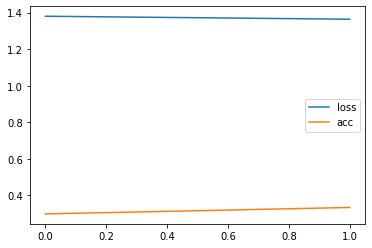

In [223]:
import matplotlib.pyplot as plt

print_acc = []
for acc in acc_hist:
    print_acc.append(acc.cpu().numpy())

plt.plot(loss_hist,label='loss')
plt.plot(print_acc,label='acc')
plt.legend()
plt.show

In [ ]:
# Confusion Matrix copy from lab

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(labels), len(vocab.stoi))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to('cuda:1')

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor.to('cuda:1'))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


## Question 3, 10 points

Next, replace the SRNN from Question 2 with a single-layer LSTM. Give the same output (training and testing accuracy as a function of epoch, as well as confusion
matrix for the test set). Comment on the differences you observe between the two models.

In [9]:
# Place code for Question 3 here
# Copy Naive LSTM from lab 11

import torch
from torch import nn

class NaiveCustomLSTM(nn.Module):
    
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        # Parameters for computing i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """
        forward: Run input x through the cell. Assumes x.shape is (batch_size, sequence_length, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        # Reshape hidden_seq tensor to (batch size, sequence length, hidden_size)
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)


In [ ]:
# For result when have time

## Question 4, 10 points

Explain how you could use the Transformer model to perform the same task you explored in Questions 2 and 3.
How would attention be useful for this text classification task? Give a precise and detailed answer. Be sure to discuss what
parts of the original Transformer you would use and what you would have to remove.

*Write your answer here.*

I believed the Transformer could be just use because we would like to feed the entire text sequence into the Transformer.

The output will be right after we put the input (becase we feed the entire sequence) (but we still need to fix the padding 0 issues if we want exactly apple to apple comparision).

Benefit:
1. It is faster due to entire text input (some say paralle)
2. It will have better relation among words because of the attension + the relation from current word to next (which can not happend in simple RNN and LSTM and also better than bi-RNN) 



## Question 5, 10 points

In Lab 13, you implemented a DQN model for tic-tac-toe. You method learned to play against a fairly dumb `expert_action` opponent, however.  Also,
DQN has proven to be less stable than other methods such as Double DQN, also discussed in Lab 13.

Explain below how you would apply double DQN and self-play to improve your tic-tac-toe agent.
Provide pseudocode for the algorithm below.

*Write your explanation and pseudocode here.*

## Question 6, 30 points

Based on your existing DQN implementation, implement the double DQN and self-play training method
you just described. After some training (don't spend too much time on training -- again, we just want to see that the model can
learn), show the result you playing a game against your learned agent.

In [10]:
# Code for training and playing goes here